# Log Gaussian Cox Process with HMC

## Data

In [1]:
# Packages
import pymc as pm
import libpysal as ps
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely

[ 273959.66438135 4049220.9034143   972595.98957796 4359604.85977962]


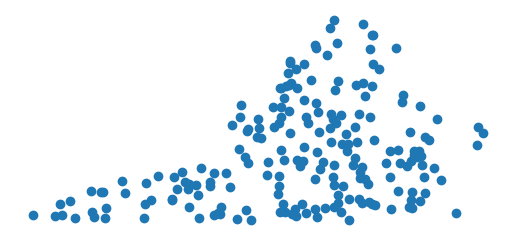

In [2]:
# Load data
f = ps.examples.get_path('vautm17n_points.shp')
fo = ps.io.open(f)
data = gpd.GeoSeries.from_file(f)

# Window size
print(data.total_bounds)

# Plot data
data.plot()
plt.axis('off')
plt.show()

(237959.66438135202, 1029959.664381352, 4032720.903414295, 4395720.903414295)

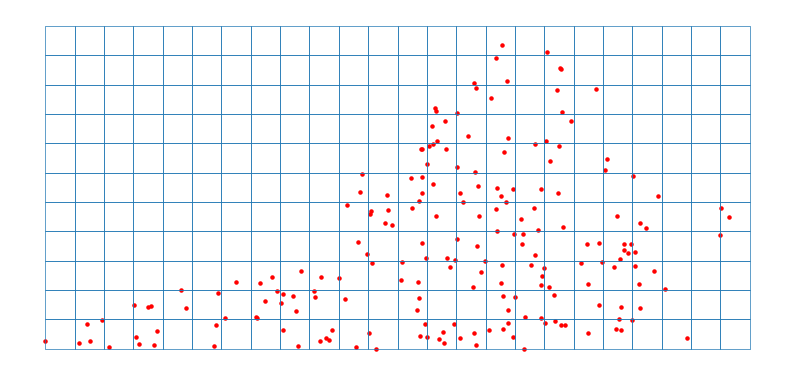

In [11]:
# Equally spaced grid

xmin, ymin, xmax, ymax = data.total_bounds
resolution = 30000

grid_cells = []

for x in np.arange(xmin, xmax, resolution):
    for y in np.arange(ymin, ymax, resolution):
        grid_cells.append(shapely.geometry.box(x, y, x + resolution, y + resolution))

grid = gpd.GeoDataFrame({'geometry': grid_cells})

# Plot grid
ax = grid.boundary.plot(figsize=(10, 10), linewidth=0.5)
data.plot(ax=ax, color='red', markersize=5)
plt.axis('off')
plt.show()

In [12]:
# Count points in each grid cell
grid['cnt'] = 0
merged = gpd.sjoin(gpd.GeoDataFrame(data), grid, how='inner', op='within')
dissolve = merged.dissolve(by='index_right', aggfunc='count')
grid.loc[dissolve.index, 'cnt'] = dissolve['cnt']

centroids = grid.centroid.get_coordinates().to_numpy()
observed = grid['cnt'].to_numpy()

c:\Users\Dangchan\anaconda3\envs\colab\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Dangchan\AppData\Local\Temp\ipykernel_4412\1950368662.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32617
Right CRS: None

  merged = gpd.sjoin(gpd.GeoDataFrame(data), grid, how='inner', op='within')


## Inference

In [13]:
with pm.Model() as lgcp_model:
    mu = pm.Normal('mu', sigma=1.0)
    rho = pm.Uniform('rho', lower=1000, upper=100000) # length scale
    variance = pm.InverseGamma('variance', alpha=1, beta=1)
    cov_func = variance * pm.gp.cov.Matern52(2, rho)
    mean_func = pm.gp.mean.Constant(mu)

In [14]:
with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    log_intensity = gp.prior('log_intensity', X=centroids) # evaluate the GP at the centroids
    intensity = pm.math.exp(log_intensity)

    rates = intensity * resolution**2 / 1000000
    cnt = pm.Poisson('count', mu=rates, observed=observed)

In [15]:
# Sample with HMC
with lgcp_model:
    trace = pm.sample(1000, tune=1000, cores=4, target_accept=0.95, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, rho, variance, log_intensity_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3952 seconds.
c:\Users\Dangchan\anaconda3\envs\colab\lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


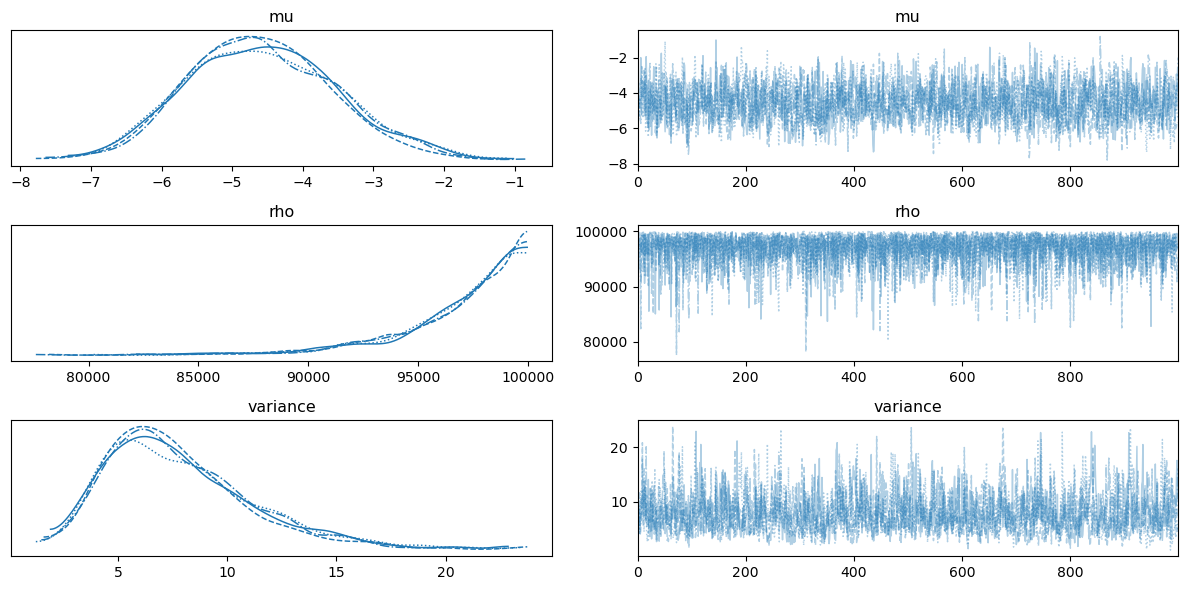

In [52]:
pm.plot_trace(trace, var_names=['mu', 'rho', 'variance'])
plt.tight_layout()
plt.show()

In [42]:
# Posterior mean
posterior_mean = pm.find_MAP(model=lgcp_model, vars=[log_intensity])

c:\Users\Dangchan\anaconda3\envs\colab\lib\site-packages\pymc\tuning\starting.py:109: UserWarning: Intermediate variables (such as Deterministic or Potential) were passed. find_MAP will optimize the underlying free_RVs instead.
  warnings.warn(


In [44]:
intensities = np.exp(posterior_mean['log_intensity'])

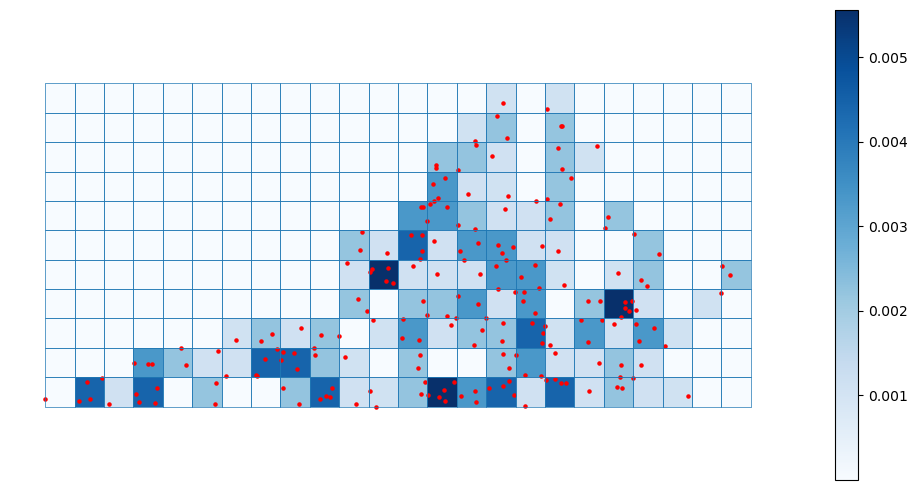

In [50]:
# Plot intensities
grid['intensity_MAP'] = intensities
ax = grid.plot(column='intensity_MAP', figsize=(10, 5), legend=True, cmap='Blues')
data.plot(ax=ax, color='red', markersize=5)
grid.boundary.plot(ax=ax, linewidth=0.5)
plt.axis('off')
plt.tight_layout()
plt.show()